# Nifty 50 Price Prediction Using Machine Learning

![NIFTY50 - M](https://i.imgur.com/9YpKzae.png)

# Introduction

Stock market indices such as SENSEX, Hang Seng, Dow Jones, etc. act as a tool to exhibit a blur idea about the overall economy of the respective country. Hence, can be used for making a surface level estimate of the overall performance of different sectors of a country.

There are endless reasons on why economy should be monitored closely. However, some of the key reasons are given below:
1. **Economic Growth:** A strong economy can result in higher level of economic growth, leading to increased production, improved standards of living and greater job opportunities.
2. **Employment:** A robust economy tends to create more jobs, reducing unemployment rates and providing individuals with income and stability.
3. **Government Revenue:** A healthy economy generates tax revenue for the government, which can be used to fund public services, infrastructure development, and social welfare programs.
4. **Investment and Innovation:** A favorable economic climate attracts domestic and foreign investments, fostering entrepreneurship and innovation. This can lead to the development of new industries, improved technology, and increased productivity.
5. **Standard of Living:** A thriving economy generally correlates with higher living standards for its citizens, as it provides access to better healthcare, education, housing, and essential goods and services.

India has two large cap indices, namely SENSEX (BSE) and NIFTY (NSE).

Here we are going to make an ML prediction model which will estimate the performance  __NIFTY50__ index on a monthly time frame.

# Concept and Project Outline

- As index price is time-series data, we will try to experiment with few models and select the one which is showing least loss metric values.
- We will start from the simpler models and then will gradually move to more complex model:
  - Linear Regression
  - ARMA Model
  - SARIMA Model
  - RandomForestRegression Model
- We will use following loss metrics.
  - R-squared Error
  - Root Mean Squared Error
- We'll select the model with least loss metric values.
- To the selected model, we will perform hyperparameter tuning, if applicable.

# Importing Required Libraries

In [ ]:
# downloading required library
!pip install pmdarima --quiet

In [ ]:
# libraries for data manipulation
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# library for visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# libraries for model building
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# library for warnings
import warnings
warnings.filterwarnings("ignore")

# Downloading NIFTY 50 Data

Here, we are downloading Nifty 50 index historical data for last 4 years.

In [ ]:
period = 4

NIFTY_multivariate = yf.download('^NSEI',
                                 interval='1D',
                                 start = datetime.today() - relativedelta(years=period),
                                 end = datetime.today())
NIFTY_multivariate.drop('Adj Close', axis=1, inplace=True)

NIFTY = NIFTY_multivariate.Close
NIFTY = NIFTY.to_frame()

[*********************100%***********************]  1 of 1 completed


# Preprocessing and EDA of Nifty 50 Data

Preprocessing and EDA is required to identify any underlying trend or pattern in the data. Here, this pattern may appear in form of a seasonal pattern or a recurring trend.

## 1. Understanding data

In [ ]:
NIFTY_multivariate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 989 entries, 2019-08-05 to 2023-08-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    989 non-null    float64
 1   High    989 non-null    float64
 2   Low     989 non-null    float64
 3   Close   989 non-null    float64
 4   Volume  989 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 46.4 KB


In [ ]:
NIFTY_multivariate.describe()

,Open,High,Low,Close,Volume
count,989.000000,989.000000,989.000000,989.000000,9.890000e+02
mean,14996.671843,15073.911607,14890.739569,14985.919624,4.430138e+05
std,3029.214639,3025.143097,3031.428996,3029.930981,2.319729e+05
min,7735.149902,8036.950195,7511.100098,7610.250000,0.000000e+00
25%,11973.549805,12022.049805,11905.349609,11966.049805,2.599000e+05
50%,15839.349609,15890.000000,15742.599609,15812.349609,3.786000e+05
75%,17619.099609,17694.099609,17499.250000,17610.400391,5.991000e+05
max,19850.900391,19991.849609,19758.400391,19979.150391,1.811000e+06


- Here we can see that data is pretty well distributed and doesn't have any outliers.
- As we are dealing with univariate data, only closing price is kept under consideration.

## 2. Checking the continuity of the downloaded data.

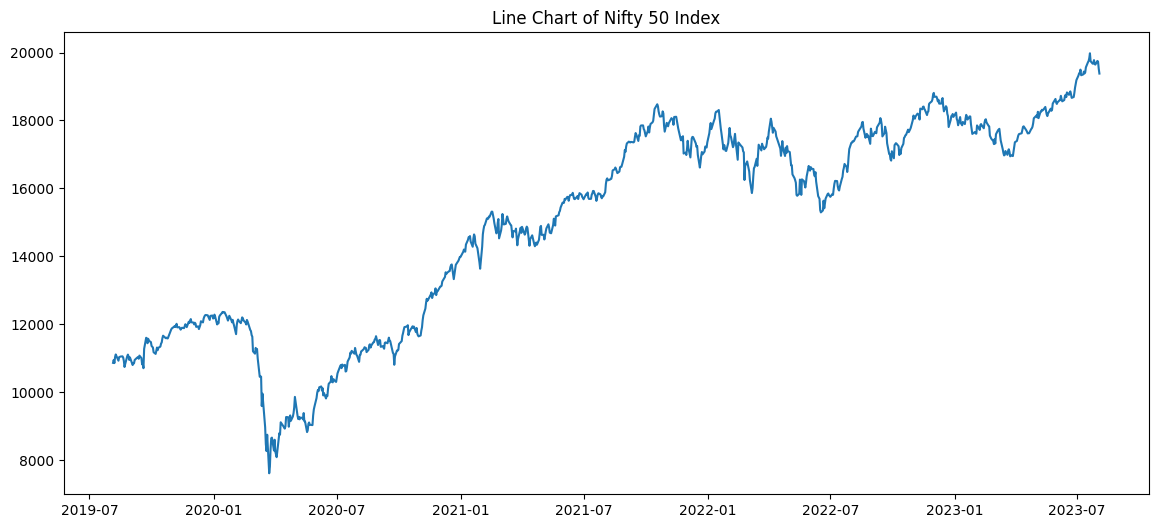

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(NIFTY)
plt.title('Line Chart of Nifty 50 Index');

- Here we can see that there is no discontinuity in the graph.
- There is no need to perform any imputation as data doesn't consist of any NaN values.

## 3. Trend of Nifty 50 Index for last 4 years.

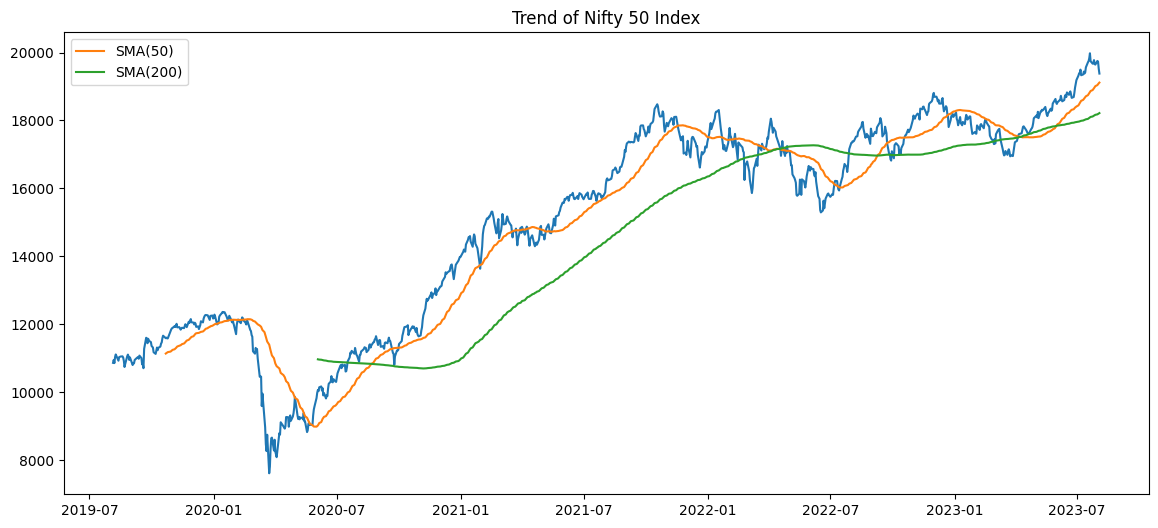

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(NIFTY)
plt.plot(NIFTY.rolling(50).mean(), label='SMA(50)')
plt.plot(NIFTY.rolling(200).mean(), label='SMA(200)')
plt.legend()
plt.title('Trend of Nifty 50 Index');

- Here we can see that Nifty 50 has been in an uptrend since last 4 years.
- All though the market is in a bullish scenario, the trend is weak, hence it will be more difficult to predict the trend of the market.

## 4. Maximum and minimum closing price of Nifty 50 data.

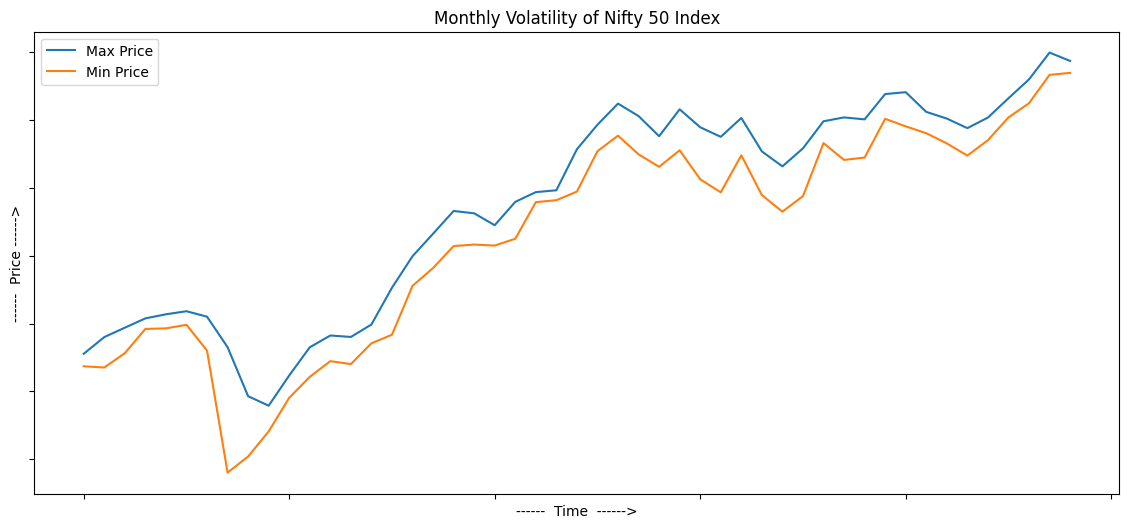

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(NIFTY.groupby([NIFTY.index.year, NIFTY.index.month])['Close'].max().values, label='Max Price')
plt.plot(NIFTY.groupby([NIFTY.index.year, NIFTY.index.month])['Close'].min().values, label='Min Price')
plt.title('Monthly Volatility of Nifty 50 Index')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.xlabel('------  Time  ------>')
plt.ylabel('------  Price ------>')
plt.legend();

- Here we can see that price has been moving in a channel, and hasn't shown a great drop in price, hence there isn't a very huge anomaly in the price.
- There isn't a great degree of volatility in the price, except the in 2020 crash.
- This suggests that if the data is smoothen out, the prediction of the price will be more accurate.

## 5. Change in volume of trades

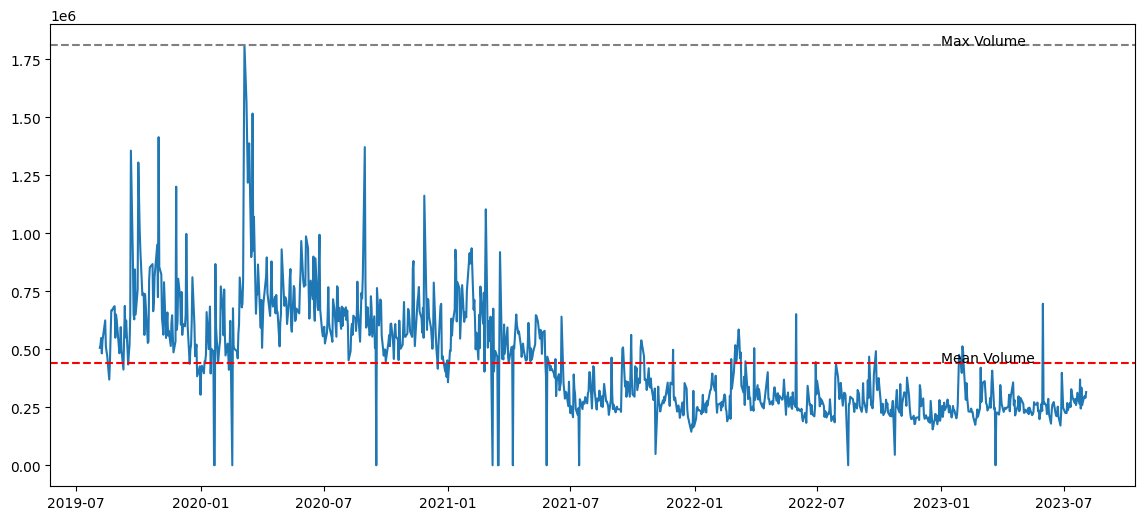

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(NIFTY_multivariate.Volume)
plt.axhline(NIFTY_multivariate.Volume.max(),
            linestyle='--',
            color='grey')
plt.text(x=pd.to_datetime(str(NIFTY_multivariate.index.year.max())),
         y=NIFTY_multivariate.Volume.max(),
         s='Max Volume')
plt.axhline(NIFTY_multivariate.Volume.mean(),
            linestyle='--',
            color='red')
plt.text(x=pd.to_datetime(str(NIFTY_multivariate.index.year.max())),
         y=NIFTY_multivariate.Volume.mean(),
         s='Mean Volume');

- We can see that there has been a huge drop in trading volume after the COVID-19 crash has settled down.
- This is due to the fact that people have started to work at their offices again and carry out their usual life-style again.

## 6. Candle Sticks chart of NIFTY 50 Index.

In [ ]:
plot = go.Figure(data = [go.Candlestick(x = NIFTY_multivariate.index,
                         open = NIFTY_multivariate['Open'],
                         high = NIFTY_multivariate['High'],
                         low = NIFTY_multivariate['Low'],
                         close = NIFTY_multivariate['Close'])])

plot.update_layout(title= 'COVID-19 Crash Effect on NIFTY 50',

                   shapes=[dict(x0='2020-03-01',
                                x1='2020-03-01',
                                y0=0,
                                y1=1,
                                xref='x',
                                yref='paper',
                                line_width=1)],

                   annotations= [dict(x='2020-03-01',
                                      y=0.05,
                                      xref='x',
                                      yref='paper',
                                      showarrow=False,
                                      xanchor='left',
                                      text='COVID-19 Crash')])

plot.show();

- Here we can see that after the COVID-19 crash, market has made it's new high and is currently at it's all time high.

# Model Selection

Here, let us make few functions which can come handy during our experimentations.

In [ ]:
# this functions is used for applying a moving average smoothening to the data
def moving_average_smoothening(moving_average_period):
  smoothen_data = NIFTY.rolling(moving_average_period).mean()
  smoothen_data.dropna(inplace=True)

  return smoothen_data

In [ ]:
# this function splits data into training, validation and test data
def data_split(dataframe, test_data_points= 20): # test_data_points is at 20 as default but can be changed, which changes the size of test set
  year_list = dataframe.index.year.unique()

  train_data = dataframe[dataframe.index.year < year_list[-1]]
  validation_test_split = dataframe[dataframe.index.year == year_list[-1]]

  validation_data = validation_test_split.iloc[:-test_data_points]
  test_data = validation_test_split.iloc[-test_data_points:]

  return train_data, validation_data, test_data

In [ ]:
# this function simply calculates the RMSE of the true value to predicted value
def RMSE(true_data, predicted_data):
  RMSE = mean_squared_error(true_data, predicted_data, squared=False)

  return RMSE

In [ ]:
# this function helps us in auto-tuning SARIMA and ARIMA, this will help us in selecting the best hyperparameter values
def SARIMA_parameter_tuning(train_data, upper_bound):
  for seasonality_metric in range(1, upper_bound+1): # upper_bound represents the maximum seasonality till which we want to find the best fitting model
    auto_arima(train_data,
               m=seasonality_metric,
               seasonal=True,
               supress_warnings=True,
               stepwise=True,
               trace=True) # trace shows all the experiments which are being conducted on the the data set

In [ ]:
# this function helps us in calculating the rolling window prediction on data, this is done for maximized accuracy in prediction
def SARIMA(x_data, y_data, observed_order, observed_seasonal_order):
  rolling_prediction = []
  frame = len(x_data)
  for i in range(0, len(y_data+1)):
    SARIMA = SARIMAX(pd.concat([x_data, y_data.head(i)]), order = observed_order, seasonal_order = observed_seasonal_order)
    SARIMA = SARIMA.fit()
    prediction = round(SARIMA.predict(start = frame+i, end = frame+i), 2)
    rolling_prediction.append(prediction.values[0])

  date_range = y_data.index
  rolling_prediction_dataframe = pd.DataFrame(zip(date_range, rolling_prediction), columns=['Date', 'Prediction'])
  rolling_prediction_dataframe.set_index('Date', inplace=True)

  return rolling_prediction_dataframe

In [ ]:
# this function calculates the residual for the predicted data with respect to true data
def calculate_residual(true_data, predicted_data):
  residual = true_data[true_data.columns[0]] - predicted_data[predicted_data.columns[0]]
  residual = pd.DataFrame(data = zip(residual.index, residual.values), columns = ['Date', 'Residual'])
  residual.set_index('Date', inplace=True)
  return residual

In [ ]:
# this function prints a graph which shows the different properties of the data
def summary_graph(data, input_title):
    plt.figure(figsize=(14,6))
    plt.plot(data)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.xlabel('Date')
    plt.ylabel('Magnitude')
    plt.title(input_title)

    # mean value line
    plt.axhline(data.mean().values[0],
                linestyle='--',
                color='red')
    plt.text(data.index[0],
             data.mean().values[0]+5,
             f'Mean Value : {round(data.mean().values[0], 2)}',
             fontsize=10)

    # standard deviation: upper band
    plt.axhline(data.mean().values[0] + data.std().values[0],
                linestyle='--',
                color='orange')
    plt.text(data.index[0],
             data.mean().values[0] + data.std().values[0]+5,
             f'Standard Deviation : {round(data.mean().values[0]+data.std().values[0], 2)}',
             fontsize=10)

    # standard deviation: lower band
    plt.axhline(data.mean().values[0] - data.std().values[0],
                linestyle='--',
                color='orange')
    plt.text(data.index[0],
             data.mean().values[0] - data.std().values[0]+5,
             f'Standard Deviation : {round(data.mean().values[0] - data.std().values[0], 2)}',
             fontsize=10)

    # minimum value
    plt.axhline(data.min().values[0],
                linestyle='-.',
                color='grey')
    plt.text(data.index[0],
             data.min().values[0]+5,
             f'Min Value : {round(data.min().values[0], 2)}',
             fontsize=10)

    # maximum value
    plt.axhline(data.max().values[0],
                linestyle='-.',
                color='grey')
    plt.text(data.index[0],
             data.max().values[0]+5,
             f'Max Value : {round(data.max().values[0], 2)}',
             fontsize=10)

In [ ]:
# this function compares the properties of two different data sets
def compare_graph(x_data, y_data, x_vertical, y_vertical, input_title):
  plt.figure(figsize=(14,6))
  plt.plot(x_data, color='steelblue', label='Graph 1')
  plt.plot(y_data, color='tomato', label='Graph 2')
  plt.xticks(visible=False)
  plt.yticks(visible=False)
  plt.xlabel('Date')
  plt.ylabel('Magnitude')
  plt.legend(loc='best')
  plt.title(input_title)

# the code used below is similar to the one used in summary_graph function with a few changes
# this section is for x_data
  plt.axhline(x_data.mean().values[0], linestyle='--', color='skyblue')
  plt.text(x_data.index[0], x_data.mean().values[0] + x_vertical, f'Mean Value : {round(x_data.mean().values[0], 2)}', fontsize=10, color='steelblue')

  plt.axhline(x_data.mean().values[0] + x_data.std().values[0], linestyle='--', color='skyblue')
  plt.text(x_data.index[0], x_data.mean().values[0] + x_data.std().values[0] + x_vertical, f'Standard Deviation : {round(x_data.mean().values[0]+x_data.std().values[0], 2)}', fontsize=10, color='steelblue')

  plt.axhline(x_data.mean().values[0] - x_data.std().values[0], linestyle='--', color='skyblue')
  plt.text(x_data.index[0], x_data.mean().values[0] - x_data.std().values[0] + x_vertical, f'Standard Deviation : {round(x_data.mean().values[0] - x_data.std().values[0], 2)}', fontsize=10, color='steelblue')

  plt.axhline(x_data.min().values[0], linestyle='-.', color='skyblue')
  plt.text(x_data.index[0], x_data.min().values[0] + x_vertical, f'Min Value : {round(x_data.min().values[0], 2)}', fontsize=10, color='steelblue')

  plt.axhline(x_data.max().values[0], linestyle='-.', color='skyblue')
  plt.text(x_data.index[0], x_data.max().values[0] + x_vertical, f'Max Value : {round(x_data.max().values[0], 2)}', fontsize=10, color='steelblue')

# this section is for y_data
  plt.axhline(y_data.mean().values[0], linestyle='--', color='goldenrod')
  plt.text(y_data.index[0], y_data.mean().values[0] + y_vertical, f'Mean Value : {round(y_data.mean().values[0], 2)}', fontsize=10, color='tomato')

  plt.axhline(y_data.mean().values[0] + y_data.std().values[0], linestyle='--', color='goldenrod')
  plt.text(y_data.index[0], y_data.mean().values[0] + y_data.std().values[0] + y_vertical, f'Standard Deviation : {round(y_data.mean().values[0]+y_data.std().values[0], 2)}', fontsize=10, color='tomato')

  plt.axhline(y_data.mean().values[0] - y_data.std().values[0], linestyle='--', color='goldenrod')
  plt.text(y_data.index[0], y_data.mean().values[0] - y_data.std().values[0] + y_vertical, f'Standard Deviation : {round(y_data.mean().values[0] - y_data.std().values[0], 2)}', fontsize=10, color='tomato')

  plt.axhline(y_data.min().values[0], linestyle='-.', color='goldenrod')
  plt.text(y_data.index[0], y_data.min().values[0] + y_vertical, f'Min Value : {round(y_data.min().values[0], 2)}', fontsize=10, color='tomato')

  plt.axhline(y_data.max().values[0], linestyle='-.', color='goldenrod')
  plt.text(y_data.index[0], y_data.max().values[0] + y_vertical, f'Max Value : {round(y_data.max().values[0], 2)}', fontsize=10, color='tomato')

  plt.show()

## Linear Regression

Linear regression is a statistical method used to model the relationship between variables by fitting a straight line to data points. It helps predict the behavior of a dependent variable based on changes in independent variables. The technique is simple and widely used in diverse fields for making predictions and understanding data patterns, but it's most effective when relationships between variables are linear.

In its simplest form, linear regression assumes a linear relationship between the variables, where the relationship can be represented as a linear equation (y = mx + b), where 'y' is the dependent variable, 'x' is the independent variable, 'm' is the slope of the line, and 'b' is the intercept.

In [ ]:
!pip install scikit-learn --quiet

In [ ]:
from sklearn.linear_model import LinearRegression

### Data Splitting

In [ ]:
LR_train_data, LR_validation_data, LR_test_data = data_split(NIFTY_multivariate)

In [ ]:
# train data
LR_train_inputs = LR_train_data[['Open','High','Low','Volume']]
LR_train_target = LR_train_data.Close

# validation data
LR_validation_inputs = LR_validation_data[['Open','High','Low','Volume']]
LR_validation_target = LR_validation_data.Close

# test data
LR_test_inputs = LR_test_data[['Open','High','Low','Volume']]
LR_test_target = LR_test_data.Close

In [ ]:
LR_model = LinearRegression()

### Validation Data Prediction

Here we are training data on train set and predicting validation data on it to check the performance.

In [ ]:
LR_train_data_model = LR_model.fit(LR_train_inputs, LR_train_target)

In [ ]:
LR_validation_prediction = LR_train_data_model.predict(LR_validation_inputs)

In [ ]:
validation_data_observations = pd.DataFrame({'True':LR_validation_target, 'Predicted':LR_validation_prediction})

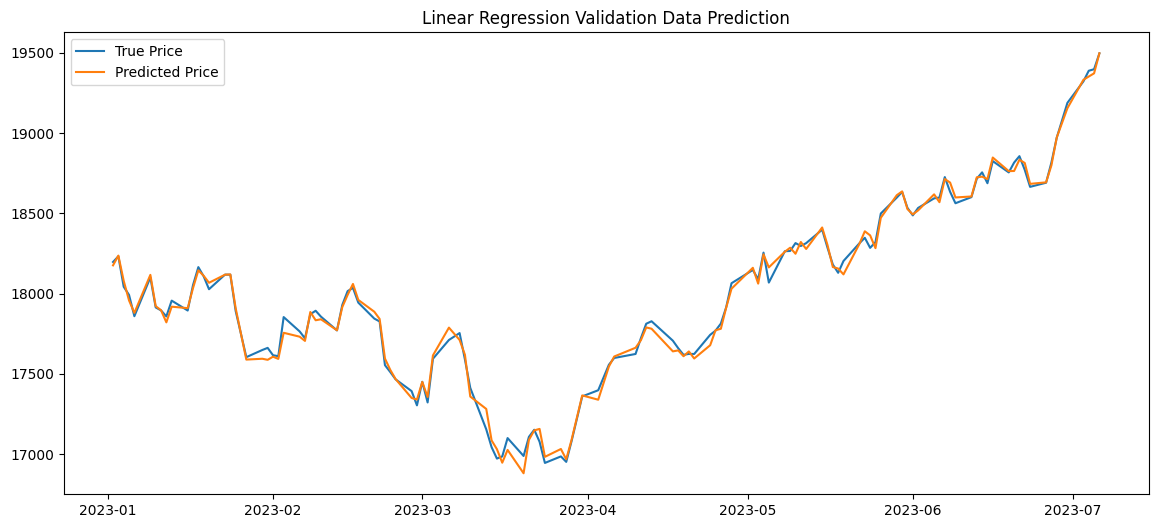

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(validation_data_observations['True'], label='True Price')
plt.plot(validation_data_observations['Predicted'], label='Predicted Price')
plt.legend()
plt.title('Linear Regression Validation Data Prediction');

Here we can see that the data is fitting pretty well. Let us find the loss metrics for the same.

#### Error Metrics

In [ ]:
RMSE(LR_validation_target, LR_validation_prediction)

37.688425794360434

In [ ]:
r2_score(LR_validation_target, LR_validation_prediction)

0.9955994359364674

The score is pretty good as it suggests low RMSE and high r-square value. This suggests that there is a lower deviation in predicted data to that of the true value, moreover, the r-square value of 0.995 suggests that there are very low external factors which can cause randomness in the data.

### Test Data Prediction

To verify or validate this, now we will perform the same on test data using validation data set.

In [ ]:
LR_validation_data_model = LR_model.fit(LR_validation_inputs, LR_validation_target)

In [ ]:
LR_test_prediction = LR_validation_data_model.predict(LR_test_inputs)

In [ ]:
test_data_observations = pd.DataFrame({'True':LR_test_target, 'Predicted':LR_test_prediction})

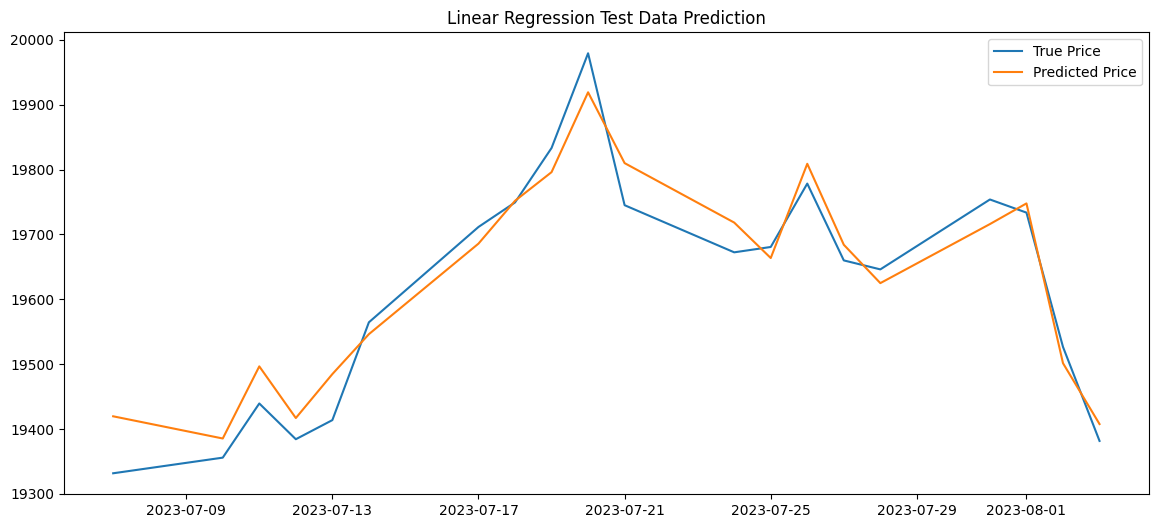

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test_data_observations['True'], label='True Price')
plt.plot(test_data_observations['Predicted'], label='Predicted Price')
plt.legend()
plt.title('Linear Regression Test Data Prediction');

#### Test Error Metrics

In [ ]:
RMSE(LR_test_target, LR_test_prediction)

42.10225046475747

In [ ]:
r2_score(LR_test_target, LR_test_prediction)

0.9438711024591128

Here we can see that although the performance is relatively lower than that in the training phase, but this is also suggesting that the data isn't overfitted, as the data is not showing a huge loss error.

### Combined Data Prediction

Now, we can combine validation and test data and predict the performance of test data.

In [ ]:
LR_combined_inputs = pd.concat([LR_train_inputs, LR_validation_inputs])
LR_combined_target = pd.concat([LR_train_target, LR_validation_target])

In [ ]:
LR_final_data_model = LR_model.fit(LR_combined_inputs, LR_combined_target)

In [ ]:
LR_final_prediction = LR_final_data_model.predict(LR_test_inputs)

In [ ]:
LR_final_data_observations = pd.DataFrame({'True':LR_test_target, 'Predicted':LR_final_prediction})

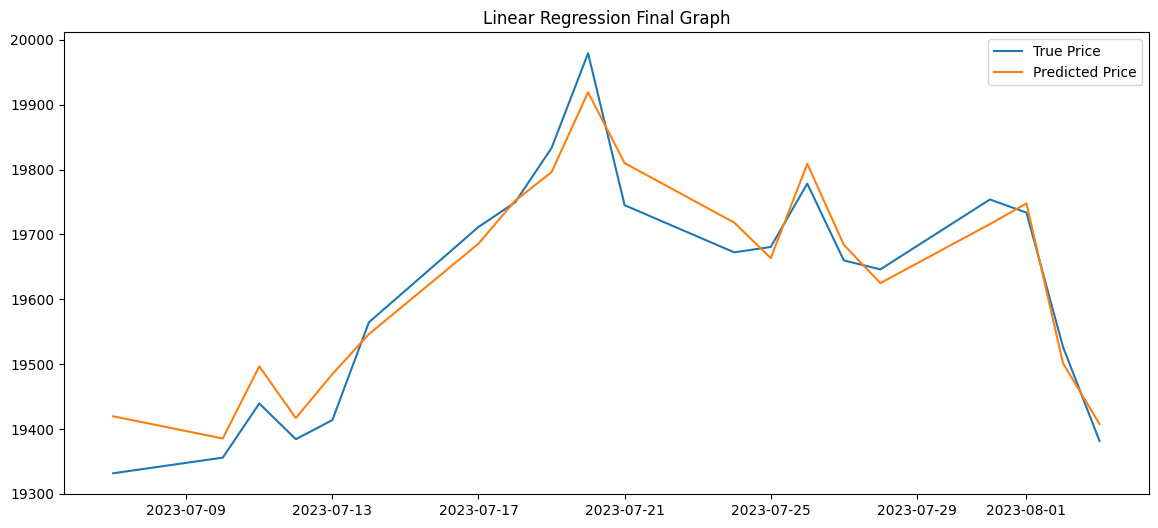

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test_data_observations['True'], label='True Price')
plt.plot(test_data_observations['Predicted'], label='Predicted Price')
plt.legend()
plt.title('Linear Regression Final Graph');

In [ ]:
RMSE(LR_test_target, LR_final_prediction)

41.96797064733114

In [ ]:
r2_score(LR_test_target, LR_final_prediction)

0.9442285635881756

Here we can say that model is performing to a satisfactory degree, and therefore can be taken under consideration.

## ARIMA Model


ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting method that captures patterns in sequential data. It combines autoregressive (AR) and moving average (MA) components, and integrates differencing to make the data stationary. ARIMA is valuable for predicting future values based on past observations, making it useful for tasks like stock market forecasting and demand prediction. However, it's essential to select appropriate parameters for optimal performance, and it may not handle very complex patterns as effectively as more advanced methods.

ARIMA model is represented as ARIMA(p, d, q):

y'(t) = c + φ₁y'(t-1) + φ₂y'(t-2) + ... + φₚy'(t-p) + θ₁ε(t-1) + θ₂ε(t-2) + ... + θₚε(t-q) + ε(t)

where y'(t) is the differenced time series and ε(t) is the white noise or error term at time 't'.

- Here we are taking the original NIFTY 50 data.
- Data points for test set is fixed at 20 days.

In [ ]:
dataframe_1 = moving_average_smoothening(1)
train_data_1, validation_data_1, test_data_1 = data_split(dataframe_1)
#SARIMA_parameter_tuning(train_data_1, 10)

- ARIMA(2,1,2)(0,0,0)[0] intercept
- AIC=7811.905

In [ ]:
observed_order_1 = (2,1,2)
observed_seasonal_order_1 = (0,0,0,0)

In [ ]:
prediction_1 = SARIMA(train_data_1, validation_data_1, observed_order_1, observed_seasonal_order_1)

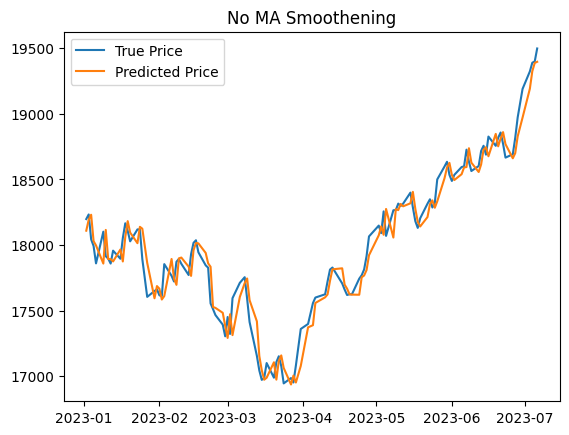

In [ ]:
plt.plot(validation_data_1, label='True Price')
plt.plot(prediction_1, label='Predicted Price')
plt.title('No MA Smoothening')
plt.legend();

#### Error Metrics

In [ ]:
RMSE(validation_data_1, prediction_1)

114.10666198057152

In [ ]:
r2_score(validation_data_1, prediction_1)

0.9596620007028717

### Final Prediction

In [ ]:
ARIMA_combined_data = pd.concat([train_data_1, validation_data_1])

In [ ]:
ARIMA_final_prediction = SARIMA(ARIMA_combined_data, test_data_1, observed_order_1, observed_seasonal_order_1)

In [ ]:
ARIMA_residual = calculate_residual(test_data_1, ARIMA_final_prediction)

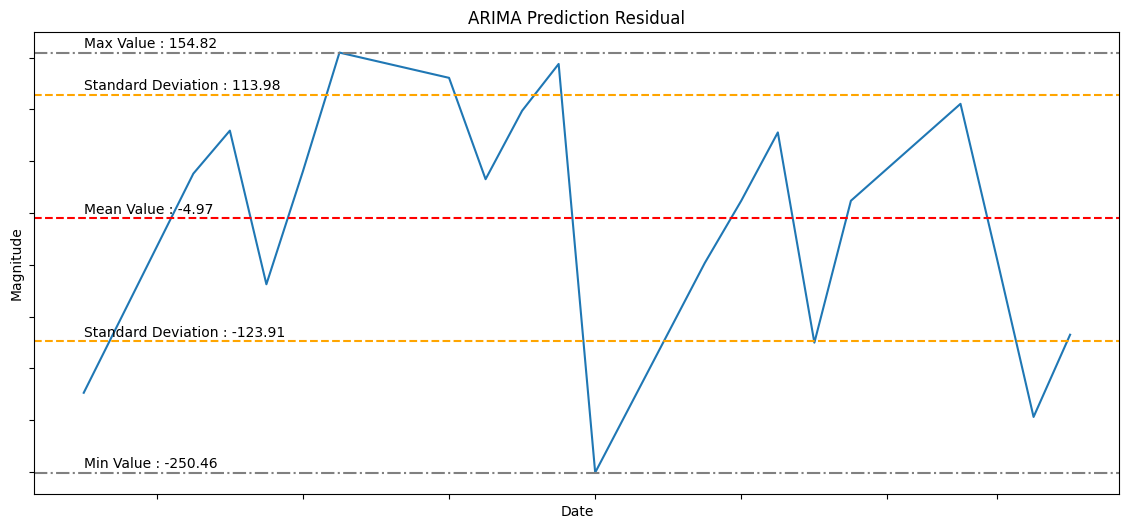

In [ ]:
summary_graph(ARIMA_residual, 'ARIMA Prediction Residual')

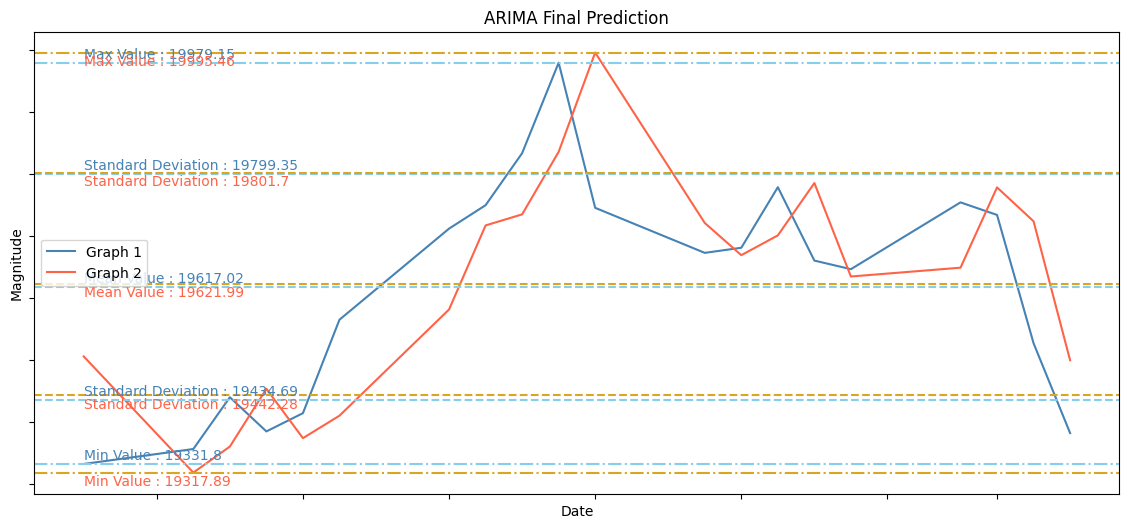

In [ ]:
compare_graph(test_data_1, ARIMA_final_prediction, 7.5, -20, 'ARIMA Final Prediction')

#### Error Metrics

In [ ]:
RMSE(test_data_1, ARIMA_final_prediction)

116.03926303394675

In [ ]:
r2_score(test_data_1, ARIMA_final_prediction)

0.5736308095654694

Here we can see that this model is performing worse than LR model, hence, our preferred model is linear regression till now.

## SARIMA Model

SARIMA (Seasonal AutoRegressive Integrated Moving Average) is an advanced time series forecasting method designed to handle seasonality in data. Building upon ARIMA, SARIMA includes additional seasonal components to model recurring patterns. It combines AutoRegressive (AR), Integrated (I), Moving Average (MA), and Seasonal (S) components, making it effective for predicting time series data with both temporal and seasonal variations. SARIMA requires careful parameter selection for optimal performance and is particularly useful for tasks involving data with clear seasonal patterns, like sales or weather data. However, like ARIMA, it may struggle with very complex or irregular patterns.


The complete SARIMA model can be expressed as:

SARIMA(p, d, q) × (P, D, Q)_s:

y'(t) = c + φ₁y'(t-1) + φ₂y'(t-2) + ... + φₚy'(t-p) + θ₁ε(t-1) + θ₂ε(t-2) + ... + θₚε(t-q) + ϕ₁y'(t-s) + ϕ₂y'(t-2s) + ... + ϕₚy'(t-Ps) + Θ₁ε(t-s) + Θ₂ε(t-2s) + ... + Θₚε(t-Qs) + ε(t)

where:

y'(t) is the differenced time series at time 't'.
c is a constant term.
φ₁, φ₂, ..., φₚ are the autoregressive coefficients for lags 1 to p.
θ₁, θ₂, ..., θₚ are the moving average coefficients for lags 1 to q.
ϕ₁, ϕ₂, ..., ϕₚ are the seasonal autoregressive coefficients for lags 1 to P, with a seasonal period of 's'.
Θ₁, Θ₂, ..., Θₚ are the seasonal moving average coefficients for lags 1 to Q, with a seasonal period of 's'.
ε(t) represents the white noise or error term at time 't'.
The model's complexity increases with the addition of seasonal components, allowing SARIMA to effectively capture both non-seasonal and seasonal patterns in time series data. Parameter selection for both non-seasonal and seasonal components is essential to ensure the model's accuracy and predictive power.

### Experiment 1

- Here we are apply a 2 period MA smoothening on data.
- Data points for test set is fixed at 20 days.

In [ ]:
dataframe_2 = moving_average_smoothening(2)
train_data_2, validation_data_2, test_data_2 = data_split(dataframe_2)
#SARIMA_parameter_tuning(train_data_2, 10)

- ARIMA(5,1,0)(2,0,0)[6]
- AIC=7020.484

In [ ]:
observed_order_2 = (5,1,0)
observed_seasonal_order_2 = (2,0,0,6)

In [ ]:
prediction_2 = SARIMA(train_data_2, validation_data_2, observed_order_2, observed_seasonal_order_2)

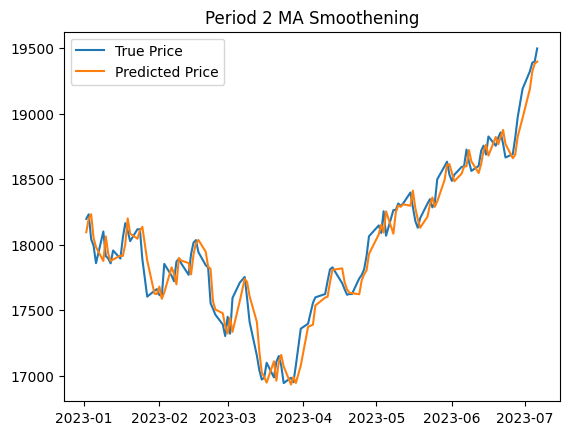

In [ ]:
plt.plot(validation_data_1, label='True Price')
plt.plot(prediction_2, label='Predicted Price')
plt.title('Period 2 MA Smoothening')
plt.legend()
plt.show();

In [ ]:
RMSE(validation_data_1, prediction_2)

112.61124864844963

In [ ]:
r2_score(validation_data_1, prediction_2)

0.960712363741794

### Experiment 2

- Here we are apply a 3 period MA smoothening on data.
- Data points for test set is fixed at 20 days.

In [ ]:
dataframe_3 = moving_average_smoothening(3)
train_data_3, validation_data_3, test_data_3 = data_split(dataframe_3)
#SARIMA_parameter_tuning(train_data_3, 10)

- ARIMA(5,1,0)(2,0,0)[6]
- AIC=6556.252

In [ ]:
observed_order_3 = (5,1,0)
observed_seasonal_order_3 = (2,0,0,6)

In [ ]:
prediction_3 = SARIMA(train_data_3, validation_data_3, observed_order_3, observed_seasonal_order_3)

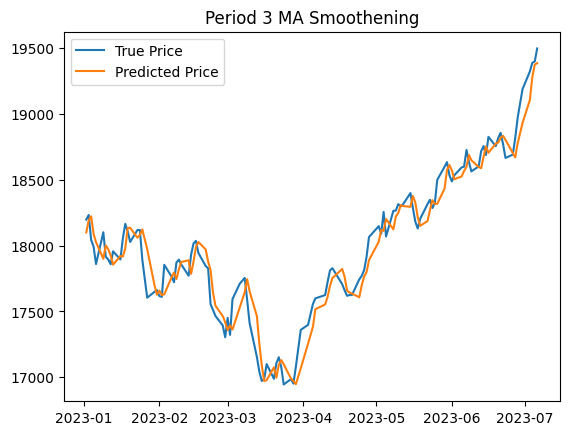

In [ ]:
plt.plot(validation_data_1, label='True Price')
plt.plot(prediction_3, label='Predicted Price')
plt.title('Period 3 MA Smoothening')
plt.legend()
plt.show();

In [ ]:
RMSE(validation_data_1, prediction_3)

123.65838004191633

In [ ]:
r2_score(validation_data_1, prediction_3)

0.9526260652131915

### Experiment 3

- Here we are apply a 4 period MA smoothening on data.
- Data points for test set is fixed at 20 days.

In [ ]:
dataframe_4 = moving_average_smoothening(4)
train_data_4, validation_data_4, test_data_4 = data_split(dataframe_4)
#SARIMA_parameter_tuning(train_data_4, 10)

- ARIMA(5,1,1)(2,0,0)[8]
- AIC=6200.731

In [ ]:
observed_order_4 = (5,1,1)
observed_seasonal_order_4 = (2,0,0,8)

In [ ]:
prediction_4 = SARIMA(train_data_4, validation_data_4, observed_order_4, observed_seasonal_order_4)

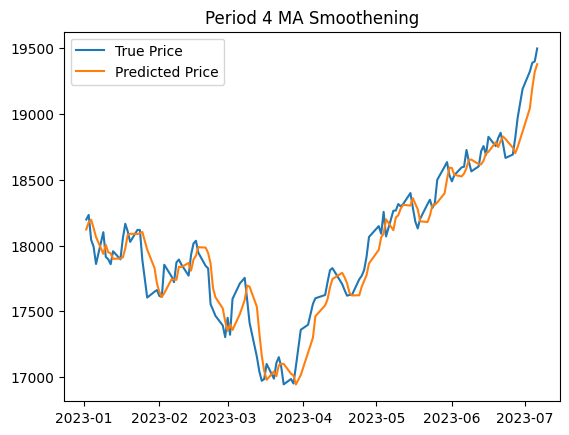

In [ ]:
plt.plot(validation_data_1, label='True Price')
plt.plot(prediction_4, label='Predicted Price')
plt.title('Period 4 MA Smoothening')
plt.legend()
plt.show();

In [ ]:
RMSE(validation_data_1, prediction_4)

139.66899503881137

In [ ]:
r2_score(validation_data_1, prediction_4)

0.9395644653105687

### Experiment 4

- Here we are apply a 5 period MA smoothening on data.
- Data points for test set is fixed at 20 days.

In [ ]:
dataframe_5 = moving_average_smoothening(5)
train_data_5, validation_data_5, test_data_5 = data_split(dataframe_5)
#SARIMA_parameter_tuning(train_data_5, 10)

- ARIMA(3,1,3)(2,0,0)[5]
- AIC=5944.789

In [ ]:
observed_order_5 = (3,1,3)
observed_seasonal_order_5 = (2,0,0,5)

In [ ]:
prediction_5 = SARIMA(train_data_5, validation_data_5, observed_order_5, observed_seasonal_order_5)

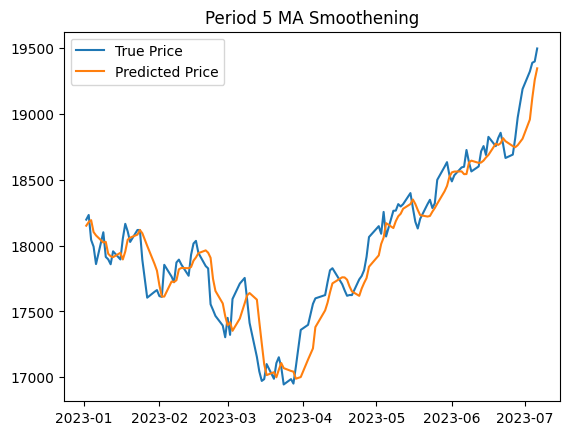

In [ ]:
plt.plot(validation_data_1, label='True Price')
plt.plot(prediction_5, label='Predicted Price')
plt.title('Period 5 MA Smoothening')
plt.legend()
plt.show();

In [ ]:
RMSE(validation_data_1, prediction_5)

156.0639923536269

In [ ]:
r2_score(validation_data_1, prediction_5)

0.9245433052964245

__Observation :__
- Visual Observations:
  - By visual assesment we can observe that period 1, 2 and 3 moving averages can be a good choice for prediction model as they are fitting the best.
  - Whereas, period 4 and 5 moving averages are smoothening data too much, resulting in worse predictions as they are loosely fitted.
- Mathematical Observations:  
  - Here we can see that the tightest fit as per RMSE is for period 2 moving average.

- From these observations, we can conclude that MA(2) smoothed NIFTY 50 data is best choice for making a prediction model.

## Training Final Model

In [ ]:
train_data_N, validation_data_N, test_data_N = data_split(dataframe_1) # Taken from 'Experiment 1' of 'Experimentation on Moving Average Selection'

In [ ]:
smoothen_data = moving_average_smoothening(2)

In [ ]:
train_data_S, validation_data_S, test_data_S = data_split(smoothen_data)

### Checking Performance of MA(2) Data

In [ ]:
# Taken form 'Experiment 2' of 'Experimentation on Moving Average Selection'
order_S = (5,1,0)
seasonal_order_S = (2,0,0,6)

### Prediction for Validation Data

In [ ]:
validation_prediction_S = SARIMA(train_data_S, validation_data_S, order_S, seasonal_order_S)

In [ ]:
validation_residual = calculate_residual(validation_data_N, validation_prediction_S)

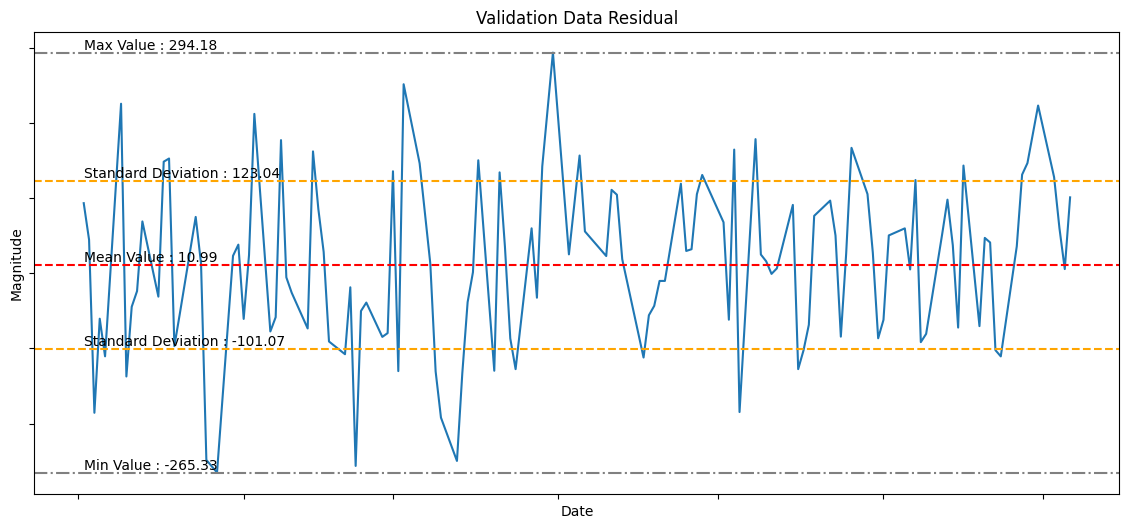

In [ ]:
summary_graph(validation_residual, 'Validation Data Residual')

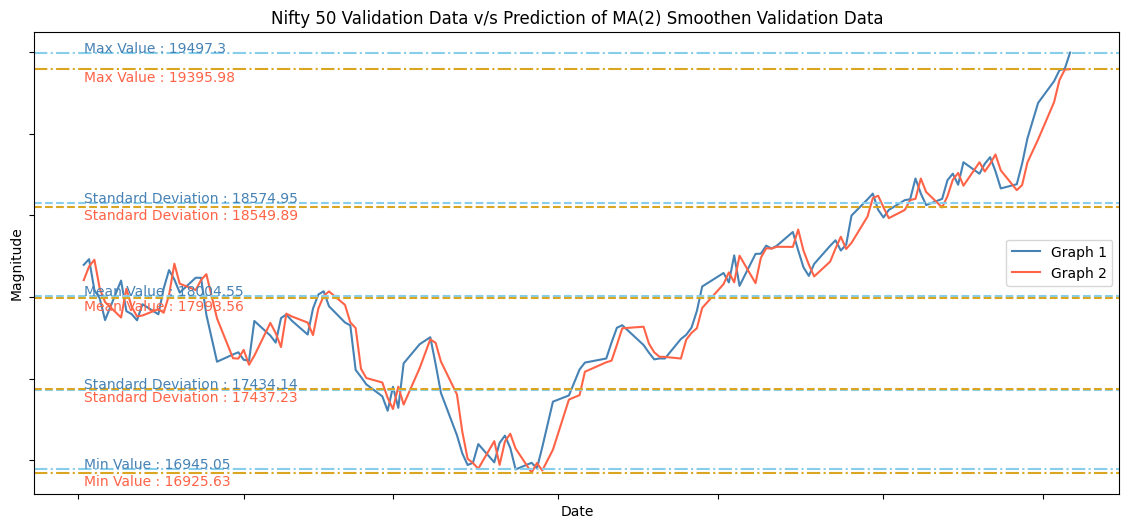

In [ ]:
compare_graph(validation_data_N, validation_prediction_S, 5, -75, 'Nifty 50 Validation Data v/s Prediction of MA(2) Smoothen Validation Data')

#### Error Metrics

In [ ]:
RMSE(validation_data_N, validation_prediction_S)

112.15069446381287

In [ ]:
r2_score(validation_data_N, validation_prediction_S)

0.9610330614548565

### Prediction for Test Data

In [ ]:
test_prediction_S = SARIMA(validation_data_S, test_data_S, order_S, seasonal_order_S)

In [ ]:
test_residual = calculate_residual(test_data_N, test_prediction_S)

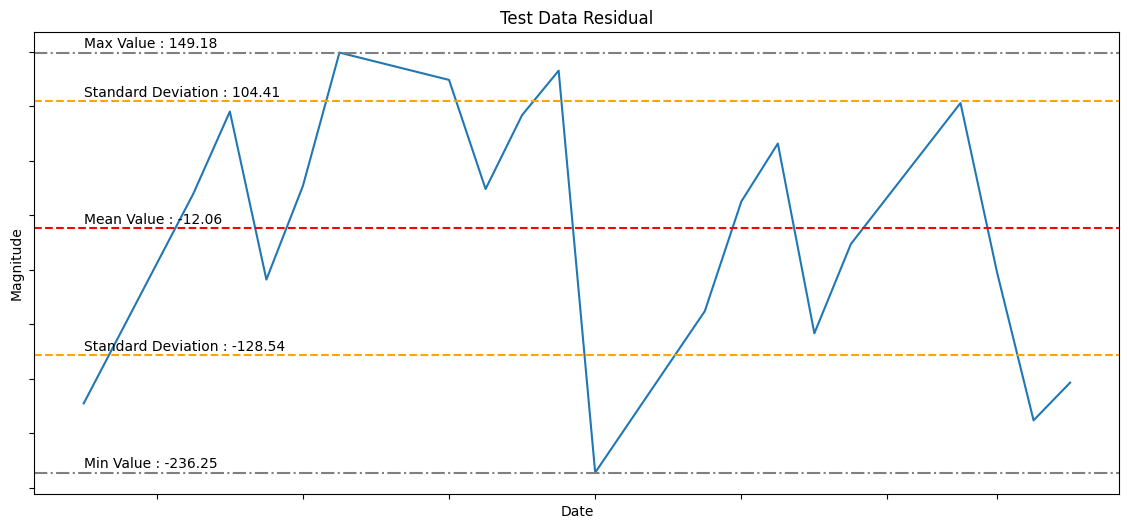

In [ ]:
summary_graph(test_residual, 'Test Data Residual')

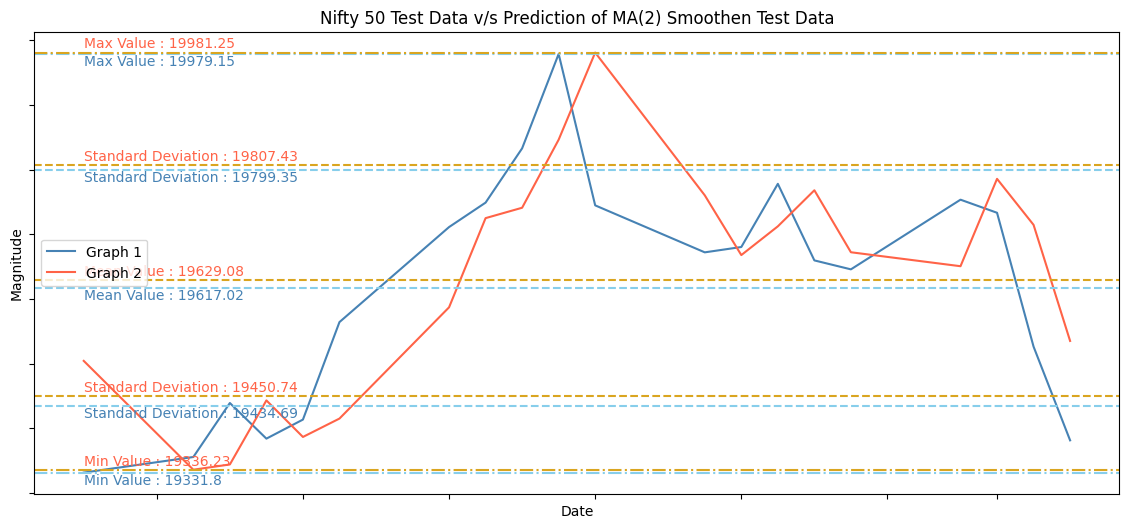

In [ ]:
compare_graph(test_data_N, test_prediction_S, -17.5, 7.5, 'Nifty 50 Test Data v/s Prediction of MA(2) Smoothen Test Data')

#### Error Metrics

In [ ]:
RMSE(test_data_N, test_prediction_S)

114.16524671395553

In [ ]:
r2_score(test_data_N, test_prediction_S)

0.5872911992029053

### Training Train + Validation Data and Predicting for Test Set

In [ ]:
combined_data_S = pd.concat([train_data_S, validation_data_S])

In [ ]:
test_prediction_final = SARIMA(combined_data_S, test_data_S, order_S, seasonal_order_S)

In [ ]:
test_residual_final = calculate_residual(test_data_N, test_prediction_final)

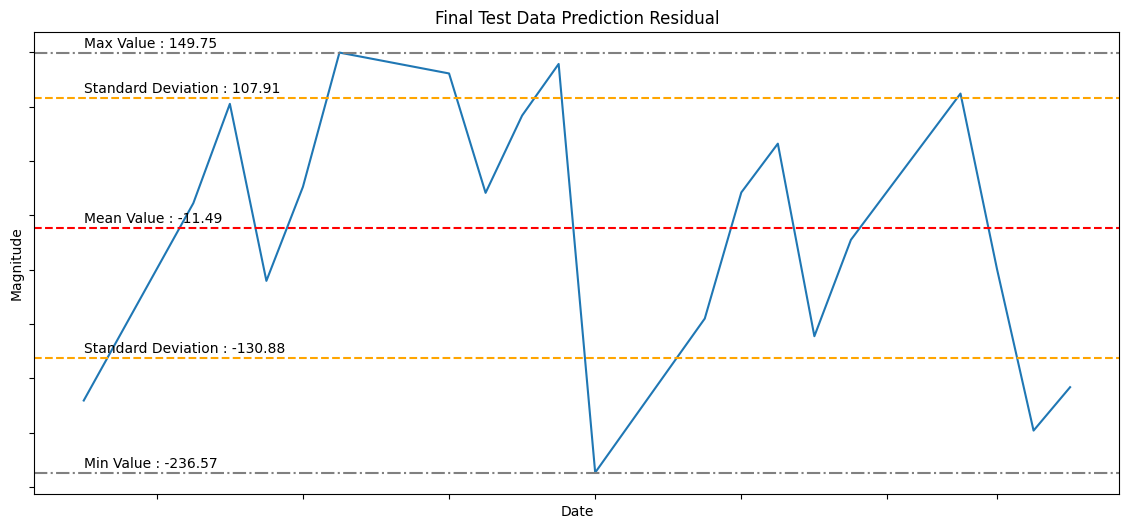

In [ ]:
summary_graph(test_residual_final, 'Final Test Data Prediction Residual')

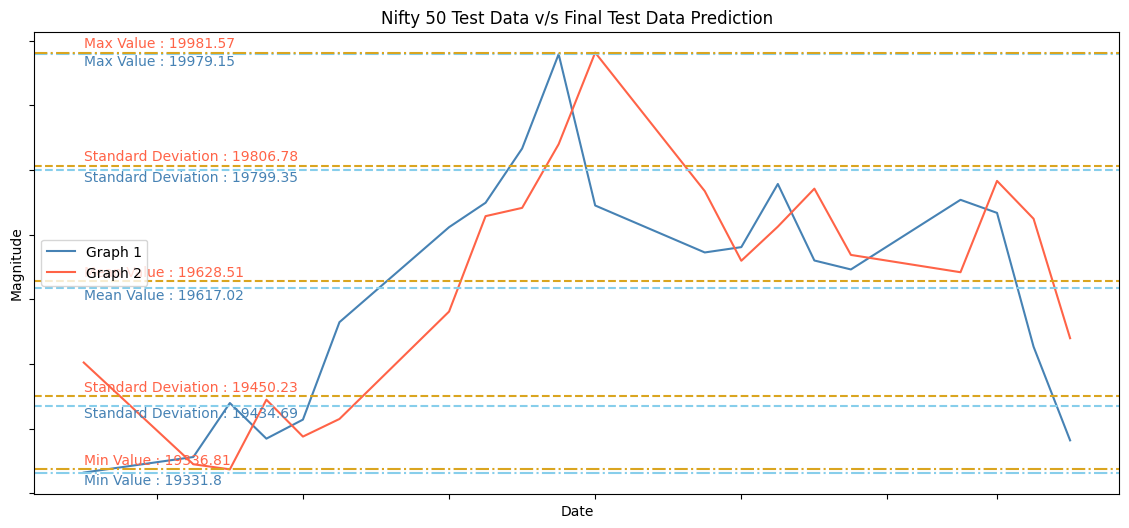

In [ ]:
compare_graph(test_data_N, test_prediction_final, -17.5, 7.5, 'Nifty 50 Test Data v/s Final Test Data Prediction')

#### Error Metrics

In [ ]:
RMSE(test_data_N, test_prediction_final)

116.93655516317432

In [ ]:
r2_score(test_data_N, test_prediction_final)

0.5670113795496565

__Observations:__
- From above observations, we can conclude that using a smaller MA value reduces the RMSE value, but reduces the R-squared value as well.

- Hence, 0.567 R-squared value suggests that there is a huge degree of unexplained factors which are accountable for the movement of the price, on the other hand, RMSE value of 116.93 suggests that there is a narrower range where the price can be expected to trade.


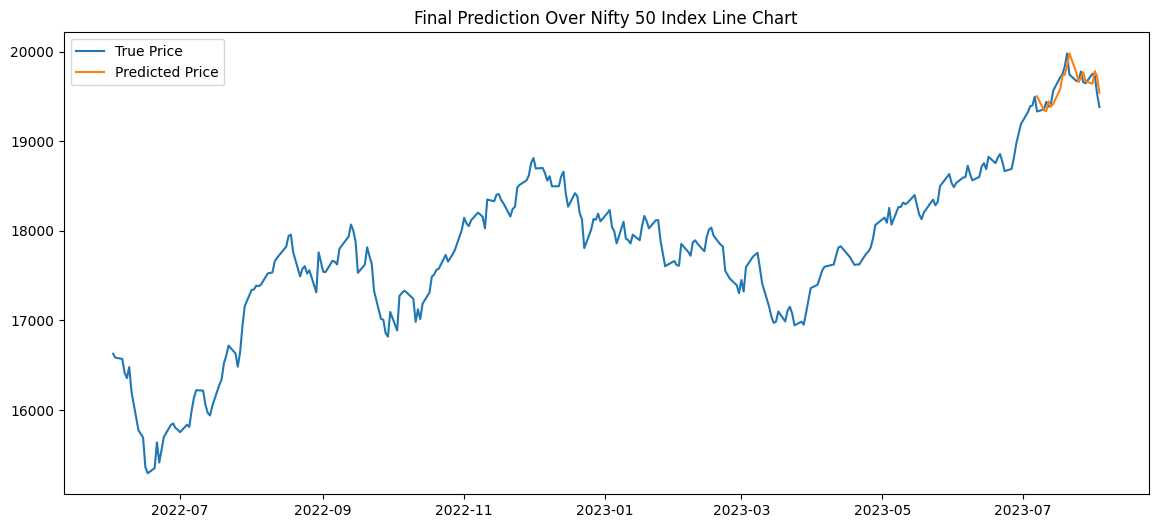

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(NIFTY[NIFTY.index > '2022-06-01'], label= 'True Price')
plt.plot(test_prediction_final, label= 'Predicted Price')
plt.legend()
plt.title('Final Prediction Over Nifty 50 Index Line Chart');

# Random Forest Regressor

The Random Forest Regressor is a powerful machine learning algorithm used for regression tasks. It belongs to the ensemble learning family and combines multiple decision trees to create a more robust and accurate predictive model. Each decision tree in the forest makes independent predictions, and the final output is determined by averaging or aggregating the predictions from all trees. This approach reduces overfitting, improves generalization, and handles complex relationships between variables. The algorithm is versatile, requiring minimal feature engineering and accommodating various types of data. However, parameter tuning is necessary to optimize performance, and the model's interpretability is lower compared to individual decision trees. Overall, Random Forest Regressor is widely used in predictive modeling due to its ability to handle large datasets and produce reliable results.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
RFR_train_data, RFR_validation_data, RFR_test_data = data_split(NIFTY_multivariate)

In [ ]:
# train data
RFR_train_inputs = RFR_train_data[['Open', 'High', 'Low', 'Volume']]
RFR_train_target = RFR_train_data.Close

# validation data
RFR_validation_inputs = RFR_validation_data[['Open', 'High', 'Low', 'Volume']]
RFR_validation_target = RFR_validation_data.Close

# test data
RFR_test_inputs = RFR_test_data[['Open', 'High', 'Low', 'Volume']]
RFR_test_target = RFR_test_data.Close

### Validation Data Prediction

In [ ]:
RFR_validation_data_model = RandomForestRegressor().fit(RFR_train_inputs, RFR_train_target)

In [ ]:
RFR_validation_prediction = RFR_validation_data_model.predict(RFR_validation_inputs)

#### Error Metrics

In [ ]:
RMSE(RFR_validation_target, RFR_validation_prediction)

136.20477339951952

In [ ]:
r2_score(RFR_validation_target, RFR_validation_prediction)

0.9425252609318531

### Test Data Prediction

In [ ]:
RFR_test_data_model = RandomForestRegressor().fit(RFR_validation_inputs, RFR_validation_target)

In [ ]:
RFR_test_prediction = RFR_test_data_model.predict(RFR_test_inputs)

#### Error Metrics

In [ ]:
RMSE(RFR_test_target, RFR_test_prediction)

250.9781201399807

In [ ]:
r2_score(RFR_test_target, RFR_test_prediction)

-0.994562341929226

RFR model is over-fitting, as the RMSE and r-square error are very great, moreoverm we already have managed to find a model which is performing way better than RFR (without hyperparameter tuning).

# Conclusion

After considering all the models and judging them around their RMSE and r-square value, we can conclude that LR can be the best fit for the current market condition, although, it may change as the cycle of market change.

# Summary:

Here we have collected the data of Nifty 50 for last 4 years and performed different experimentations to find the best model for price prediction.

Here, we have taken:
- Linear Regression
- ARIMA
- SARIMA
- Random Forest Regressor

under consideration.

From above experimentations, we have concluded that linear regression model is the best performing model for now and will give the lowest RMSE and highest r-square score.

# Future Work:

- Find better performing models (like LSTM and others)
- Use ensemble methods (boosting method)
- Infuse NLP (LLMs) for more advanced analysis and greater user-fiendly interface.
- Deploying this to a website using reflex.

# References:

- https://www.youtube.com/playlist?list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3
- https://jovian.com/kartikaye-madhok/collections/time-series-predictive